In [ ]:
# should process a grid search for lstm?
do_grid_search = False

Reload Snorkel Session

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

Load Train, Dev and Test sentences. Default Split is 1:1:1

In [2]:
from ksnorkel import KSUtils

train_sent, dev_sent, test_sent = KSUtils.split_sentences(session)
print("Amount of sentences: {} train, {} dev and {} test".format(len(train_sent), len(dev_sent), len(test_sent)))

Amount of docs: 9645
Document splitted: 3215 train, 3215 dev and 3215 test
Amount of sentences: 27763 train, 27526 dev and 27823 test


Now generate all candidates for each sentence set

In [4]:
from snorkel.models import Candidate, candidate_subclass
from snorkel.candidates import PretaggedCandidateExtractor

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])
candidate_extractor = PretaggedCandidateExtractor(ChemicalDisease, ['Chemical', 'Disease'])

for k, sents in enumerate([train_sent,dev_sent, test_sent]):
    candidate_extractor.apply(sents, split=k, clear=True)
    print("Number of candidates:", session.query(ChemicalDisease).filter(ChemicalDisease.split == k).count())

  0%|          | 0/27763 [00:00<?, ?it/s]

Clearing existing...
Running UDF...


  0%|          | 68/27526 [00:00<00:40, 676.98it/s]

Number of candidates: 5861
Clearing existing...
Running UDF...


  0%|          | 116/27823 [00:00<00:24, 1110.14it/s]

Number of candidates: 6165
Clearing existing...
Running UDF...


100%|██████████| 27823/27823 [00:16<00:00, 1655.99it/s]

Number of candidates: 6437


Load CTD Dataset as gold label for drug disease associations
(see http://ctdbase.org/downloads/)

In [5]:
import gzip


ctd_drug_disease_associations = set()
with gzip.open('data/CTD_chemicals_diseases.tsv.gz','r') as f:
    for l in f:
        line = str(l).replace('b\'', '').replace('\\n\'', '')
        # skip comments
        if line.startswith('#'):
            continue
        # split line into components
        components = line.split('\\t')
        # add MESH:
        if not components[1].startswith('MESH:'):
            components[1] = "MESH:" + components[1]
        if not components[4].startswith('MESH:'):
            components[4] = "MESH:" + components[4]
        
        #print("{} {}".format(components[1], components[4]))
        key = frozenset((components[1], components[4]))
        ctd_drug_disease_associations.add(key)

print("Read {} drug-disease associations from CTD".format(len(ctd_drug_disease_associations)))
       
def cand_in_ctd_drug_disease_associations(c):
    key = frozenset((c.chemical_cid, c.disease_cid))
    #print(key)
    return 1 if key in ctd_drug_disease_associations else -1

Read 2414520 drug-disease associations from CTD


Label all candidates of ChemicalDiesease with CTD als a ground truth

In [6]:
from ksnorkel import KSUtils

KSUtils.add_gold_labels_for_candidates(session, ChemicalDisease, cand_in_ctd_drug_disease_associations)

Clearing existing gold labels...
Adding gold labels to training candidates...
Labeld 2635 positive and 3226 negative samples in train
Adding gold labels to develop candidates...
Labeld 2910 positive and 3255 negative samples in dev
Adding gold labels to test candidates...
Labeld 2875 positive and 3562 negative samples in test
Finished - commiting to database...
Commit complete!
Labeld 8420 positive and 10043 negative samples


Labeling function for ctd

In [7]:
def LF_cd_in_CTD(c):
    if cand_in_ctd_drug_disease_associations(c) == 1:
        return 1
    return -1

In [8]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)
def LF_d_induced_by_c_tight(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)

def LF_induce_name(c):
    return 1 if 'induc' in c.chemical.get_span().lower() else 0     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return 1 if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else 0

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_treat_d(c):
    return rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d_wide(c):
    return rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)

def LF_c_d(c):
    return 1 if ('{{A}} {{B}}' in get_tagged_text(c)) else 0

def LF_c_induced_d(c):
    return 1 if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else 0

def LF_improve_before_disease(c):
    return rule_regex_search_before_B(c, 'improv.*', -1)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return -1 if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else 0

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)

def LF_induced_other(c):
    return rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)

def LF_far_c_d(c):
    return rule_regex_search_btw_AB(c, '.{100,5000}', -1)

def LF_far_d_c(c):
    return rule_regex_search_btw_BA(c, '.{100,5000}', -1)

def LF_risk_d(c):
    return rule_regex_search_before_B(c, 'risk of ', 1)

def LF_develop_d_following_c(c):
    return 1 if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else 0

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return 1 if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else 0

def LF_measure(c):
    return -1 if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else 0

def LF_level(c):
    return -1 if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else 0

def LF_neg_d(c):
    return -1 if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else 0


def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, dis_start - dist // 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    return 0


LFs = [
    LF_cd_in_CTD,
    LF_c_cause_d,
    LF_c_d,
    LF_c_induced_d,
    LF_c_treat_d,
    LF_c_treat_d_wide,
    LF_d_following_c,
    LF_d_induced_by_c,
    LF_d_induced_by_c_tight,
    LF_d_treat_c,
    LF_develop_d_following_c,
    LF_far_c_d,
    LF_far_d_c,
    LF_improve_before_disease,
    LF_in_patient_with,
    LF_induce,
    LF_induce_name,
    LF_induced_other,
    LF_level,
    LF_measure,
    LF_neg_d,
    LF_risk_d,
    LF_treat_d,
    LF_uncertain,
    LF_weak_assertions,
    LF_closer_chem,
    LF_closer_dis
]

In [9]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

%time L_train = labeler.apply(split=0)
L_train

  0%|          | 14/5861 [00:00<00:43, 133.37it/s]

Clearing existing...
Running UDF...


100%|██████████| 5861/5861 [00:26<00:00, 222.04it/s]


CPU times: user 26.5 s, sys: 172 ms, total: 26.7 s
Wall time: 26.6 s


<5861x25 sparse matrix of type '<class 'numpy.int64'>'
	with 9889 stored elements in Compressed Sparse Row format>

We can also view statistics about the resulting label matrix.

* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [10]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_cd_in_CTD,0,1.000000,0.505886,0.234772
LF_c_cause_d,1,0.015015,0.015015,0.008531
LF_c_d,2,0.008360,0.008360,0.004948
LF_c_induced_d,3,0.000000,0.000000,0.000000
LF_c_treat_d,4,0.056816,0.056816,0.029517
LF_c_treat_d_wide,5,0.101519,0.101519,0.050162
LF_d_following_c,6,0.000171,0.000171,0.000000
LF_d_induced_by_c,7,0.009384,0.009384,0.005460
LF_d_induced_by_c_tight,8,0.003071,0.003071,0.001536
LF_d_treat_c,9,0.024228,0.024228,0.011602


In [11]:
from snorkel.annotations import load_gold_labels

L_dev = labeler.apply_existing(split=1)
L_test = labeler.apply_existing(split=2)

L_gold_dev = load_gold_labels(session, annotator_name='gold',split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

  0%|          | 15/6165 [00:00<00:43, 142.61it/s]

Clearing existing...
Running UDF...


  0%|          | 13/6437 [00:00<00:53, 120.58it/s]

Clearing existing...
Running UDF...


100%|██████████| 6437/6437 [00:45<00:00, 142.14it/s]


Grid search on generative model to find the best parameter configuration

In [12]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch
from snorkel.learning.structure import DependencySelector

MAX_DEPS = 5

ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
deps = set(list(deps)[0:min(len(deps), MAX_DEPS)])

print("Using {} dependencies".format(len(deps)))



# use random search to optimize the generative model
param_grid = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50,100], # ,150],
    'reg_param' : [1e-3],
}

model_class_params = {'lf_propensity' : False }#, 'deps': deps}

searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=5, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev) #, deps=deps)
run_stats

train_marginals = gen_model.marginals(L_train)

Using 5 dependencies
[1] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.9668027693946387
[GenerativeModel] Model saved as <GenerativeModel_0>.
[GenerativeModel] Model saved as <GenerativeModel_best>.
[2] Testing step_size = 1.00e-04, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[GenerativeModel] Model saved as <GenerativeModel_1>.
[GenerativeModel] Model saved as <GenerativeModel_best>.
[3] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[4] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[5] Testing step_size = 1.00e-03, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 1.0
[GenerativeModel] Model 

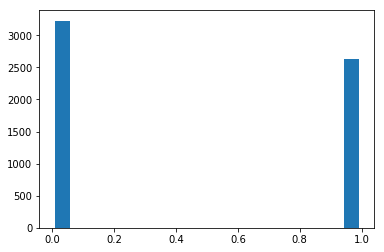

In [13]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [14]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 1.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 2910 | FP: 0 | TN: 3255 | FN: 0



In [15]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 1.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 2875 | FP: 0 | TN: 3562 | FN: 0



In [16]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 1.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 2910 | FP: 0 | TN: 3255 | FN: 0



In [17]:
train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).order_by(ChemicalDisease.id).all()
dev_cands   = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).order_by(ChemicalDisease.id).all()
test_cands  = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).order_by(ChemicalDisease.id).all()

all_cands = []
all_cands.extend(train_cands)
all_cands.extend(dev_cands)
all_cands.extend(test_cands)

print("Amount of all candidates: {}".format(len(all_cands)))

Amount of all candidates: 18463


In [18]:
from snorkel.learning.pytorch import LSTM

#train_kwargs = {
#    'lr':              0.01,
#    'embedding_dim':   75,
#    'hidden_dim':      75,
#    'n_epochs':        100,
#    'dropout':         0.5,
#    'rebalance':       0.25,
#    'seed':            1701
#}

if not do_grid_search:
    # Best Configuration after grid search
    train_kwargs = {
        'batchsize':       64,
        'lr':              0.001,
        'embedding_dim':   100,
        'hidden_dim':      150,
        'n_epochs':        100,
        'dropout':         0.25,
        'rebalance':       0.0,
        'seed':            1701
    }

    lstm = LSTM(n_threads=10)
    lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev,use_cudnn=True, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=5861  #epochs=100  batch size=64


/home/kroll/.conda/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (20.56s)	Average loss=0.682373	Dev F1=40.46
[LSTM] Epoch 2 (50.85s)	Average loss=0.600755	Dev F1=57.07
[LSTM] Epoch 3 (80.37s)	Average loss=0.470878	Dev F1=58.37
[LSTM] Epoch 4 (109.53s)	Average loss=0.382380	Dev F1=57.11
[LSTM] Epoch 5 (138.89s)	Average loss=0.326456	Dev F1=57.98
[LSTM] Epoch 6 (166.93s)	Average loss=0.263276	Dev F1=60.41
[LSTM] Epoch 7 (196.69s)	Average loss=0.218974	Dev F1=62.64
[LSTM] Epoch 8 (224.62s)	Average loss=0.192227	Dev F1=61.55
[LSTM] Epoch 9 (252.19s)	Average loss=0.173997	Dev F1=64.10
[LSTM] Epoch 10 (279.39s)	Average loss=0.168245	Dev F1=65.62
[LSTM] Epoch 11 (306.92s)	Average loss=0.143658	Dev F1=60.68
[LSTM] Epoch 12 (334.29s)	Average loss=0.126132	Dev F1=62.33
[LSTM] Epoch 13 (361.68s)	Average loss=0.114463	Dev F1=63.55
[LSTM] Epoch 14 (389.15s)	Average loss=0.098069	Dev F1=63.71
[LSTM] Epoch 15 (416.31s)	Average loss=0.116841	Dev F1=55.48
[LSTM] Epoch 16 (444.18s)	Average loss=0.100873	Dev F1=64.05
[LSTM] Epoch 17 (471.99s)	Average lo

In [ ]:
from snorkel.learning import RandomSearch
from snorkel.learning.pytorch import LSTM

if do_grid_search:
    seed = 12345
    num_model_search = 25

    # search over this parameter grid
    param_grid = {}
    param_grid['batch_size'] = [64, 128]
    param_grid['lr']         = [1e-4, 1e-3, 1e-2]
    #param_grid['l1_penalty'] = [1e-6, 1e-4, 1e-2]
    #param_grid['l2_penalty'] = [1e-6, 1e-4, 1e-2]
    param_grid['rebalance']  = [0.0,0.25, 0.5]
    param_grid['embedding_dim'] = [75, 100, 125]
    param_grid['hidden_dim'] = [50, 100, 150]
    param_grid['dropout'] = [0, 0.25, 0.5]

    model_class_params = {
        'n_threads':1
    }


    model_hyperparams = {
        'n_epochs': 100,
        'print_freq': 25,
        'dev_ckpt_delay': 0.5,
        'X_dev': dev_cands,
        'Y_dev': L_gold_dev,
    }

    #lstm = LSTM(n_threads=1)

    searcher = RandomSearch(LSTM, param_grid, train_cands, train_marginals,
                            n=num_model_search, seed=seed,
                            model_class_params=model_class_params,
                            model_hyperparams=model_hyperparams)

    print("Discriminitive Model Parameter Space (seed={}):".format(seed))
    for i, params in enumerate(searcher.search_space()):
        print("{} {}".format(i, params))

    disc_model, run_stats = searcher.fit(X_valid=dev_cands, Y_valid=L_gold_dev, n_threads=1)
    lstm = disc_model

In [ ]:
if do_grid_search:
    run_stats

In [19]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.708, Recall: 0.732, F1 Score: 0.720


In [20]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.732
Neg. class accuracy: 0.756
Precision            0.708
Recall               0.732
F1                   0.72
----------------------------------------
TP: 2104 | FP: 869 | TN: 2693 | FN: 771



In [21]:
lstm.save_marginals(session, all_cands)

Saved 18463 marginals


In [22]:
from ksnorkel import KSUtils

all_sents = []
all_sents.extend(train_sent)
all_sents.extend(dev_sent)
all_sents.extend(test_sent)

header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('document_id', 'sentence_id', 'cand_id', 'chemical_cid', 'chemical_span', 'disease_cid', 'disease_span')
%time KSUtils.save_binary_relation_as_tsv('results/chemical_disease_association.tsv', session, all_cands, all_sents, header_str, 'chemical_cid', 'disease_cid')

Storing candidate labels into result file: results/chemical_disease_association.tsv
Amount of candidates: 18463
Load mariginals from db...
Marginals loaded!
Building sentence to document map...
Map built!
Saved 8398 positive predicitions for binary relation!
CPU times: user 1min 44s, sys: 2.93 s, total: 1min 47s
Wall time: 1min 47s


In [23]:
lstm.save("chemical_disease.lstm")

[LSTM] Model saved as <chemical_disease.lstm>
